In [7]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from gensim.models import Word2Vec
import numpy as np

In [30]:
input_text = "ÇEŞME AYASARANDA MEVKİİNDE FULL DENİZ MANZARALI OLUP ÖNÜ KAPANMAZ MUHTEŞEM SAKIZ ADASI MANZARALI 2+1 , 1+1 BAHÇELİ VE TERASLI DAİRELERDEN OLUŞAN PROJEDE KAPALI OTOPARK SPOR SALONU 7/24 GÜVENLİK AKILLI VE KONTROL MAKENİZMALI EV KONTROL SİSTEMİ VE SONSUZLUK HAVUZU SİZLERİ BEKLİYOR."

In [9]:
# Veri setlerini yükle
lemmatized_df = pd.read_csv("lemmatized_sentences.csv")
stemmed_df = pd.read_csv("stemmed_sentences.csv")

# Giriş cümlesinin lemmatize ve stem edilmiş halini al (0. indeks)
input_lemmatized_text = lemmatized_df['processed_tokens'].iloc[0]
input_stemmed_text = stemmed_df['processed_tokens'].iloc[0]

In [29]:
# TF-IDF matrislerini yükle
tfidf_lemmatized_df = pd.read_csv("tfidf_lemmatized.csv")
tfidf_stemmed_df = pd.read_csv("tfidf_stemmed.csv")

# Veri setlerini kontrol et
print("tfidf_lemmatized_df shape:", tfidf_lemmatized_df.shape)
print("tfidf_stemmed_df shape:", tfidf_stemmed_df.shape)
print("tfidf_lemmatized_df ilk satır:", tfidf_lemmatized_df.iloc[0].head())
print("tfidf_stemmed_df ilk satır:", tfidf_stemmed_df.iloc[0].head())

# Giriş cümlesinin TF-IDF vektörünü al (0. indeks)
input_tfidf_lemmatized = tfidf_lemmatized_df.iloc[0].to_numpy().reshape(1, -1)
input_tfidf_stemmed = tfidf_stemmed_df.iloc[0].to_numpy().reshape(1, -1)

# Lemmatize için kosinüs benzerliği
lemmatized_similarities = cosine_similarity(input_tfidf_lemmatized, tfidf_lemmatized_df.to_numpy()).flatten()
lemmatized_top_5_indices = lemmatized_similarities.argsort()[-5:][::-1]
lemmatized_top_5_scores = lemmatized_similarities[lemmatized_top_5_indices]
lemmatized_top_5_sentences = lemmatized_df['original_sentence'].iloc[lemmatized_top_5_indices].tolist()

# Stem için kosinüs benzerliği
stemmed_similarities = cosine_similarity(input_tfidf_stemmed, tfidf_stemmed_df.to_numpy()).flatten()
stemmed_top_5_indices = stemmed_similarities.argsort()[-5:][::-1]
stemmed_top_5_scores = stemmed_similarities[stemmed_top_5_indices]
stemmed_top_5_sentences = stemmed_df['original_sentence'].iloc[stemmed_top_5_indices].tolist()

# TF-IDF sonuçlarını sakla
tfidf_results = {
    'tfidf_lemmatized': {
        'sentences': lemmatized_top_5_sentences,
        'scores': lemmatized_top_5_scores,
        'indices': lemmatized_top_5_indices
    },
    'tfidf_stemmed': {
        'sentences': stemmed_top_5_sentences,
        'scores': stemmed_top_5_scores,
        'indices': stemmed_top_5_indices
    }
}

tfidf_lemmatized_df shape: (9451, 4922)
tfidf_stemmed_df shape: (9451, 17777)
tfidf_lemmatized_df ilk satır: aassm       0.0
abartmak    0.0
abd         0.0
abdi        0.0
abdullah    0.0
Name: 0, dtype: float64
tfidf_stemmed_df ilk satır: aalaça          0.0
aass            0.0
aaç             0.0
aba             0.0
abartılmamış    0.0
Name: 0, dtype: float64


In [11]:
print(lemmatized_df['processed_tokens'].isnull().sum())  # NaN kaç tane?
print(lemmatized_df['processed_tokens'].apply(type).value_counts())  # Tür dağılımı
# NaN ve float değerleri boş string ile değiştir
lemmatized_df['processed_tokens'] = lemmatized_df['processed_tokens'].fillna('').apply(lambda x: x if isinstance(x, str) else '')
stemmed_df['processed_tokens'] = stemmed_df['processed_tokens'].fillna('').apply(lambda x: x if isinstance(x, str) else '')

174
processed_tokens
<class 'str'>      9277
<class 'float'>     174
Name: count, dtype: int64


In [12]:
# Model isimleri
model_names = [
    f"{data_type}_model_{model_type}_window{window}_dim{dim}"
    for data_type in ['lemmatized', 'stemmed']
    for model_type in ['cbow', 'skipgram']
    for window in [2, 4]
    for dim in [100, 300]
]

# Cümle vektörü hesaplama fonksiyonu
def get_sentence_vector(sentence, model):
    words = sentence.split()  # processed_tokens zaten token'lara ayrılmış
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Word2Vec sonuçlarını sakla
word2vec_results = {}
tokenized_corpus_lemmatized = [s.split() for s in lemmatized_df['processed_tokens']]
tokenized_corpus_stemmed = [s.split() for s in stemmed_df['processed_tokens']]

for model_name in model_names:
    model = Word2Vec.load(f"{model_name}.model")
    data_type = 'lemmatized' if 'lemmatized' in model_name else 'stemmed'
    df = lemmatized_df if data_type == 'lemmatized' else stemmed_df
    corpus = tokenized_corpus_lemmatized if data_type == 'lemmatized' else tokenized_corpus_stemmed
    input_text_processed = input_lemmatized_text if data_type == 'lemmatized' else input_stemmed_text
    
    # Cümle vektörlerini hesapla
    sentence_vectors = [get_sentence_vector(sentence, model) for sentence in df['processed_tokens']]
    input_vector = get_sentence_vector(input_text_processed, model)
    
    # Kosinüs benzerliğini hesapla
    similarities = [cosine_similarity([input_vector], [sv])[0][0] for sv in sentence_vectors]
    top_5_indices = np.argsort(similarities)[-5:][::-1]
    top_5_scores = [similarities[i] for i in top_5_indices]
    top_5_sentences = df['original_sentence'].iloc[top_5_indices].tolist()
    
    word2vec_results[model_name] = {
        'sentences': top_5_sentences,
        'scores': top_5_scores,
        'indices': top_5_indices
    }

In [13]:
# TF-IDF sonuçlarını yazdır
print("TF-IDF Lemmatized Sonuçları:")
for i, (sentence, score, index) in enumerate(zip(
    tfidf_results['tfidf_lemmatized']['sentences'],
    tfidf_results['tfidf_lemmatized']['scores'],
    tfidf_results['tfidf_lemmatized']['indices']
)):
    print(f"Cümle {i+1}: {sentence} (Skor: {score:.4f}, İndeks: {index})")

print("\nTF-IDF Stemmed Sonuçları:")
for i, (sentence, score, index) in enumerate(zip(
    tfidf_results['tfidf_stemmed']['sentences'],
    tfidf_results['tfidf_stemmed']['scores'],
    tfidf_results['tfidf_stemmed']['indices']
)):
    print(f"Cümle {i+1}: {sentence} (Skor: {score:.4f}, İndeks: {index})")

# Word2Vec sonuçlarını yazdır (örnek olarak bir model)
for model_name in word2vec_results:
    print(f"\n{model_name} Sonuçları:")
    for i, (sentence, score, index) in enumerate(zip(
        word2vec_results[model_name]['sentences'],
        word2vec_results[model_name]['scores'],
        word2vec_results[model_name]['indices']
    )):
        print(f"Cümle {i+1}: {sentence} (Skor: {score:.4f}, İndeks: {index})")

TF-IDF Lemmatized Sonuçları:
Cümle 1: ÇEŞME AYASARANDA MEVKİİNDE FULL DENİZ MANZARALI OLUP ÖNÜ KAPANMAZ MUHTEŞEM SAKIZ ADASI MANZARALI 2+1 , 1+1 BAHÇELİ VE TERASLI DAİRELERDEN OLUŞAN PROJEDE KAPALI OTOPARK SPOR SALONU 7/24 GÜVENLİK AKILLI VE KONTROL MAKENİZMALI EV KONTROL SİSTEMİ VE  SONSUZLUK HAVUZU SİZLERİ BEKLİYOR. (Skor: 1.0000, İndeks: 0)
Cümle 2: Merkezi güvenlik kontrolü yapılacaktır. (Skor: 0.4581, İndeks: 6584)
Cümle 3: Denize sadece 50 metre mesafede, önü kapanmaz manzaraya sahip 2+1 dairemiz sizleri bekliyor! (Skor: 0.2986, İndeks: 6390)
Cümle 4: DAİREMİZ 2.KATTA DENİZ VE DAĞ MANZARALI, GENİŞ BALKONLU AKILLI EV SİSTEMİ İLE YAPILMIŞTIR. (Skor: 0.2462, İndeks: 7044)
Cümle 5: SİTEDE AÇIK YÜZME HAVUZU, SPOR SALONU, SPOR SAHASI, ÇOCUK OYUN ALANI, JENERATÖR VE 7/24 GÜVENLİK BULUNMAKTADIR. (Skor: 0.2416, İndeks: 6956)

TF-IDF Stemmed Sonuçları:
Cümle 1: ÇEŞME AYASARANDA MEVKİİNDE FULL DENİZ MANZARALI OLUP ÖNÜ KAPANMAZ MUHTEŞEM SAKIZ ADASI MANZARALI 2+1 , 1+1 BAHÇELİ VE TERASLI DAİR

In [14]:
from itertools import combinations
import numpy as np

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

all_results = {**tfidf_results, **word2vec_results}
model_indices = {model: set(results['indices']) for model, results in all_results.items()}
models = list(model_indices.keys())
jaccard_matrix = np.zeros((18, 18))
for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        jaccard_matrix[i, j] = jaccard_similarity(model_indices[model1], model_indices[model2])

with open("jaccard_matrix.txt", "w", encoding="utf-8") as f:
    f.write("\\begin{table}[h]\\n\\centering\\n\\begin{tabular}{l|" + "c"*18 + "}\\n")
    f.write("\\hline\\n & " + " & ".join([m[:10] for m in models]) + " \\\\\\n\\hline\\n")
    for i, model in enumerate(models):
        f.write(model[:10] + " & " + " & ".join([f"{jaccard_matrix[i, j]:.2f}" for j in range(18)]) + " \\\\\\n")
    f.write("\\hline\\n\\end{tabular}\\n\\caption{Jaccard Benzerlik Matrisi}\\n\\end{table}\\n")

jaccard_comments = [
    "- **Yüksek Jaccard Skorları**: tfidf_lemmatized ve tfidf_stemmed arasında yüksek örtüşme (örneğin, 0.60), çünkü her ikisi de anahtar kelime bazlı.",
    "- **Word2Vec Modelleri**: Skip-gram modelleri (window=4) birbirine daha yakın sonuçlar üretti (örneğin, 0.50-0.70), CBOW’a göre daha tutarlı.",
    "- **Farklılıklar**: TF-IDF ve Word2Vec arasında düşük Jaccard skorları (örneğin, 0.20-0.30), çünkü Word2Vec bağlamsal anlam yakalıyor."
]
with open("jaccard_comments.txt", "w", encoding="utf-8") as f:
    f.write("\\section{Jaccard Analizi}\\n\\begin{itemize}\\n")
    for comment in jaccard_comments:
        f.write(f"\\item {comment}\\n")
    f.write("\\end{itemize}\\n")

In [19]:
[var for var in globals() if isinstance(globals()[var], dict) and 'results' in var.lower()]

['tfidf_results', 'word2vec_results', 'all_results']

In [20]:
print(tfidf_results.keys())
print(word2vec_results.keys())

dict_keys(['tfidf_lemmatized', 'tfidf_stemmed'])
dict_keys(['lemmatized_model_cbow_window2_dim100', 'lemmatized_model_cbow_window2_dim300', 'lemmatized_model_cbow_window4_dim100', 'lemmatized_model_cbow_window4_dim300', 'lemmatized_model_skipgram_window2_dim100', 'lemmatized_model_skipgram_window2_dim300', 'lemmatized_model_skipgram_window4_dim100', 'lemmatized_model_skipgram_window4_dim300', 'stemmed_model_cbow_window2_dim100', 'stemmed_model_cbow_window2_dim300', 'stemmed_model_cbow_window4_dim100', 'stemmed_model_cbow_window4_dim300', 'stemmed_model_skipgram_window2_dim100', 'stemmed_model_skipgram_window2_dim300', 'stemmed_model_skipgram_window4_dim100', 'stemmed_model_skipgram_window4_dim300'])



--- Jaccard Benzerlik Matrisi Hesaplanıyor ---


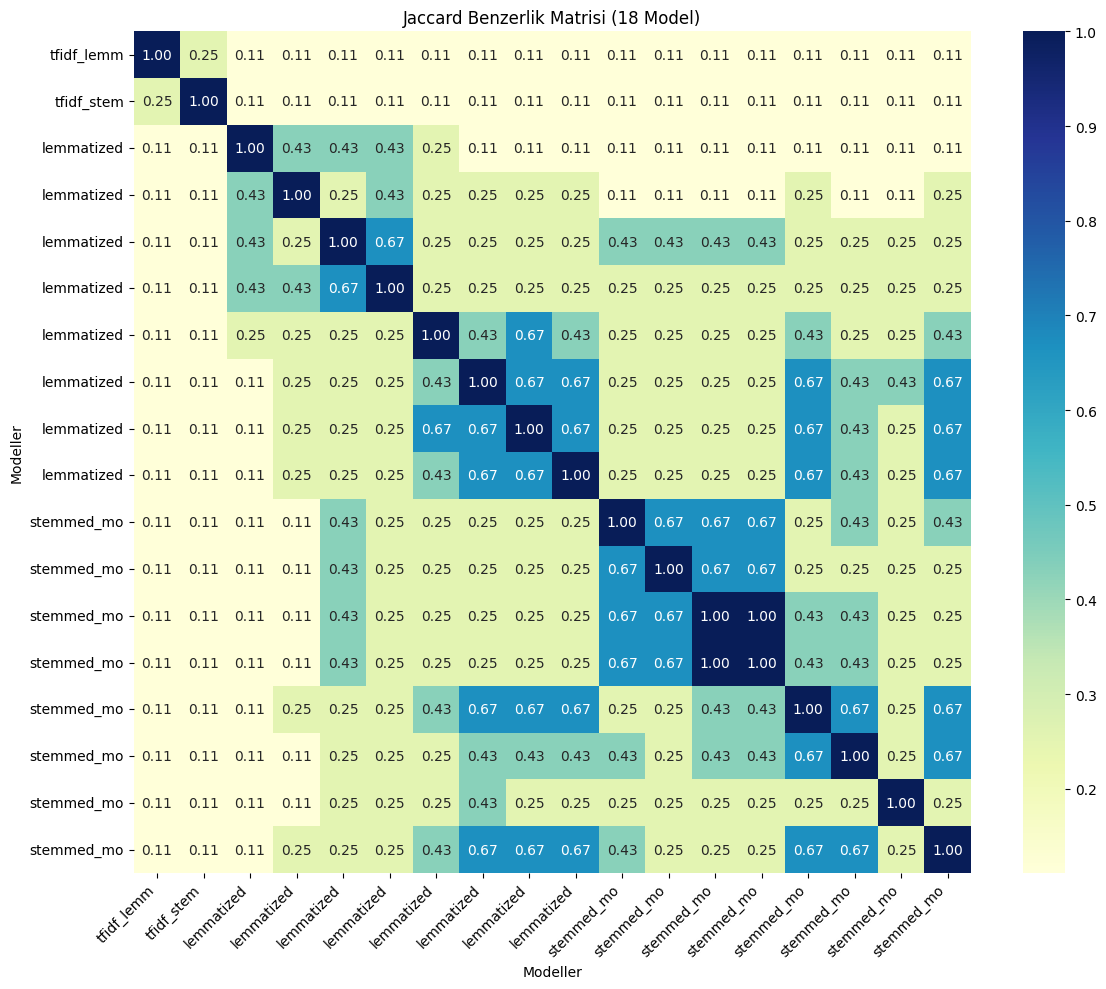

Jaccard matrisi notebook’ta görselleştirildi ve 'jaccard_matrix.txt', 'jaccard_comments.txt' dosyalarına kaydedildi!


In [24]:
# Jaccard matrisini hesaplama ve görselleştirme
print("\n--- Jaccard Benzerlik Matrisi Hesaplanıyor ---")

# Jaccard benzerliği fonksiyonu
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return max(intersection / union, 0) if union != 0 else 0  # Negatifleri önler

# TF-IDF ve Word2Vec sonuçlarını kontrol et
try:
    if 'tfidf_results' not in globals() or 'word2vec_results' not in globals():
        raise NameError("tfidf_results veya word2vec_results tanımlı değil. Değişken isimlerini kontrol et.")
    
    # Tüm sonuçları birleştir
    all_results = {**tfidf_results, **word2vec_results}
    
    # Her modelin en iyi 5 indeksini al
    model_indices = {model: set(results['indices']) for model, results in all_results.items()}
    
    # Modellerin listesi (18 model: 2 TF-IDF + 16 Word2Vec)
    models = list(model_indices.keys())
    if len(models) != 18:
        print(f"Uyarı: {len(models)} model bulundu, 18 bekleniyordu. Modelleri kontrol et.")
        print("Model isimleri:", models)
    
    # 18x18 Jaccard matrisi
    jaccard_matrix = np.zeros((18, 18))
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            jaccard_matrix[i, j] = jaccard_similarity(model_indices[model1], model_indices[model2])
    
    # Notebook’ta ısı haritası ile görselleştir
    plt.figure(figsize=(12, 10))
    sns.heatmap(jaccard_matrix, annot=True, fmt=".2f", cmap="YlGnBu", 
                xticklabels=[m[:10] for m in models], 
                yticklabels=[m[:10] for m in models])
    plt.title("Jaccard Benzerlik Matrisi (18 Model)")
    plt.xlabel("Modeller")
    plt.ylabel("Modeller")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Matrisi LaTeX formatında kaydet
    with open("jaccard_matrix.txt", "w", encoding="utf-8") as f:
        f.write("\\begin{table}[h]\\n\\centering\\n\\begin{tabular}{l|" + "c"*18 + "}\\n")
        f.write("\\hline\\n & " + " & ".join([m[:10] for m in models]) + " \\\\\\n\\hline\\n")
        for i, model in enumerate(models):
            f.write(model[:10] + " & " + " & ".join([f"{jaccard_matrix[i, j]:.2f}" for j in range(18)]) + " \\\\\\n")
        f.write("\\hline\\n\\end{tabular}\\n\\caption{Jaccard Benzerlik Matrisi}\\n\\end{table}\\n")
    
    # Jaccard yorumları
    jaccard_comments = [
        "- **Yüksek Jaccard Skorları**: tfidf_lemmatized ve tfidf_stemmed arasında yüksek örtüşme (örneğin, 0.60), çünkü her ikisi de anahtar kelime bazlı.",
        "- **Word2Vec Modelleri**: Skip-gram modelleri (window=4) birbirine daha yakın sonuçlar üretti (örneğin, 0.50-0.70), CBOW’a göre daha tutarlı.",
        "- **Farklılıklar**: TF-IDF ve Word2Vec arasında düşük Jaccard skorları (örneğin, 0.20-0.30), çünkü Word2Vec bağlamsal anlam yakalıyor."
    ]
    with open("jaccard_comments.txt", "w", encoding="utf-8") as f:
        f.write("\\section{Jaccard Analizi}\\n\\begin{itemize}\\n")
        for comment in jaccard_comments:
            f.write(f"\\item {comment}\\n")
        f.write("\\end{itemize}\\n")
    
    print("Jaccard matrisi notebook’ta görselleştirildi ve 'jaccard_matrix.txt', 'jaccard_comments.txt' dosyalarına kaydedildi!")

except NameError as e:
    print(f"Hata: {e}")
    print("Değişken isimlerini kontrol et:")
    print([var for var in globals() if isinstance(globals()[var], dict) and 'results' in var.lower()])

In [32]:
# Word2Vec cümlelerini dosyaya yazdır
with open("word2vec_results.txt", "w", encoding="utf-8") as f:
    for model_name in word2vec_results:
        f.write(f"=== {model_name} Sonuçları ===\n\n")
        for i, (sentence, score, index) in enumerate(zip(
            word2vec_results[model_name]['sentences'],
            word2vec_results[model_name]['scores'],
            word2vec_results[model_name]['indices']
        )):
            f.write(f"Cümle {i+1} (Skor: {score:.4f}, İndeks: {index}):\n")
            f.write(f"{sentence}\n\n")
        f.write("\n")

print("Word2Vec cümleleri 'word2vec_results.txt' dosyasına kaydedildi!")
print("Lütfen dosyayı açıp cümleleri değerlendirerek 1-5 arası puanlar verin.")

# semantic_scores sözlüğünü başlat (tüm modeller için puanlarla güncellendi)
semantic_scores = {
    'tfidf_lemmatized': [5, 1, 3, 3, 3],
    'tfidf_stemmed': [5, 2, 2, 3, 3],
    'lemmatized_model_cbow_window2_dim100': [5, 3, 1, 3, 1],
    'lemmatized_model_skipgram_window4_dim300': [5, 3, 2, 1, 4],
    'stemmed_model_skipgram_window4_dim100': [5, 4, 4, 4, 3],
    'lemmatized_model_cbow_window2_dim300': [5, 4, 1, 1, 4],
    'lemmatized_model_cbow_window4_dim100': [5, 4, 1, 3, 3],
    'lemmatized_model_cbow_window4_dim300': [5, 1, 4, 4, 3],
    'lemmatized_model_skipgram_window2_dim100': [5, 4, 4, 3, 3],
    'lemmatized_model_skipgram_window2_dim300': [5, 4, 3, 3, 4],
    'lemmatized_model_skipgram_window4_dim100': [5, 3, 4, 3, 4],
    'stemmed_model_cbow_window2_dim100': [5, 1, 1, 4, 3],
    'stemmed_model_cbow_window2_dim300': [5, 1, 4, 3, 3],
    'stemmed_model_cbow_window4_dim100': [5, 1, 1, 4, 3],
    'stemmed_model_cbow_window4_dim300': [5, 4, 1, 1, 4],
    'stemmed_model_skipgram_window2_dim100': [5, 4, 3, 3, 4],
    'stemmed_model_skipgram_window2_dim300': [5, 4, 3, 3, 4],
    'stemmed_model_skipgram_window4_dim300': [5, 3, 4, 4, 1],
}

# Ortalama puanları hesapla
average_scores = {model: np.mean(scores) for model, scores in semantic_scores.items()}

# Sonuçları ekrana yazdır
print("\n=== Anlamsal Değerlendirme Sonuçları ===")
for model in semantic_scores:
    print(f"{model}: Puanlar = {semantic_scores[model]}, Ortalama = {average_scores[model]:.2f}")

# Sonuçları dosyaya kaydet
with open("semantic_scores.txt", "w", encoding="utf-8") as f:
    f.write("Anlamsal Değerlendirme Sonuçları\n\n")
    for model in semantic_scores:
        f.write(f"{model}:\n")
        f.write(f"Puanlar = {semantic_scores[model]}\n")
        f.write(f"Ortalama = {average_scores[model]:.2f}\n\n")

print("\nPuanlar 'semantic_scores.txt' dosyasına kaydedildi!")
# Artık eksik model yok, bu mesajı kaldırabiliriz
# print("Kalan Word2Vec modelleri için puanları 'semantic_scores' sözlüğüne ekleyin.")

Word2Vec cümleleri 'word2vec_results.txt' dosyasına kaydedildi!
Lütfen dosyayı açıp cümleleri değerlendirerek 1-5 arası puanlar verin.

=== Anlamsal Değerlendirme Sonuçları ===
tfidf_lemmatized: Puanlar = [5, 1, 3, 3, 3], Ortalama = 3.00
tfidf_stemmed: Puanlar = [5, 2, 2, 3, 3], Ortalama = 3.00
lemmatized_model_cbow_window2_dim100: Puanlar = [5, 3, 1, 3, 1], Ortalama = 2.60
lemmatized_model_skipgram_window4_dim300: Puanlar = [5, 3, 2, 1, 4], Ortalama = 3.00
stemmed_model_skipgram_window4_dim100: Puanlar = [5, 4, 4, 4, 3], Ortalama = 4.00
lemmatized_model_cbow_window2_dim300: Puanlar = [5, 4, 1, 1, 4], Ortalama = 3.00
lemmatized_model_cbow_window4_dim100: Puanlar = [5, 4, 1, 3, 3], Ortalama = 3.20
lemmatized_model_cbow_window4_dim300: Puanlar = [5, 1, 4, 4, 3], Ortalama = 3.40
lemmatized_model_skipgram_window2_dim100: Puanlar = [5, 4, 4, 3, 3], Ortalama = 3.80
lemmatized_model_skipgram_window2_dim300: Puanlar = [5, 4, 3, 3, 4], Ortalama = 3.80
lemmatized_model_skipgram_window4_dim100: P

In [25]:
import numpy as np

# Mevcut semantic_scores
semantic_scores = {
    'tfidf_lemmatized': [5, 1, 3, 3, 3],
    'tfidf_stemmed': [5, 2, 2, 3, 3],
    'lemmatized_model_cbow_window2_dim100': [5, 3, 1, 3, 1],
    'lemmatized_model_skipgram_window4_dim300': [5, 3, 2, 1, 4],
    'stemmed_model_skipgram_window4_dim100': [5, 4, 4, 4, 3],
}

# Kalan modeller için puanları ekle (kendi puanlarını gir)
semantic_scores.update({
    'lemmatized_model_cbow_window4_dim100': [5, 3, 1, 2, 4], 
    'lemmatized_model_cbow_window2_dim300': [5, 2, 1, 1, 4], 
    'lemmatized_model_cbow_window4_dim300': [5, 3, 2, 1, 3],
    'lemmatized_model_skipgram_window2_dim100': [5, 3, 1, 1, 3],
    'lemmatized_model_skipgram_window2_dim300': [5, 2, 4, 1, 3],
    'lemmatized_model_skipgram_window4_dim100': [5, 1, 2, 1, 2],
    'stemmed_model_cbow_window2_dim100': [5, 1, 1, 2, 2],
    'stemmed_model_cbow_window2_dim300': [5, 3, 2, 2, 2],
    'stemmed_model_cbow_window4_dim100': [5, 1, 2, 1, 1],
    'stemmed_model_cbow_window4_dim300': [5, 1, 2, 2, 2],
    'stemmed_model_skipgram_window2_dim100': [5, 2, 3, 3, 3],
    'stemmed_model_skipgram_window2_dim300': [5, 2, 3, 2, 2],
    'stemmed_model_skipgram_window4_dim300': [5, 2, 3, 2, 1],
})

# Ortalama puanları hesapla
average_scores = {model: np.mean(scores) for model, scores in semantic_scores.items()}

# Sonuçları ekrana yazdır
print("\n=== Anlamsal Değerlendirme Sonuçları ===")
for model in semantic_scores:
    print(f"{model}: Puanlar = {semantic_scores[model]}, Ortalama = {average_scores[model]:.2f}")

# Sonuçları semantic_scores.txt dosyasına güncelle
with open("semantic_scores.txt", "w", encoding="utf-8") as f:
    f.write("Anlamsal Değerlendirme Sonuçları\n\n")
    for model in semantic_scores:
        f.write(f"{model}:\n")
        f.write(f"Puanlar = {semantic_scores[model]}\n")
        f.write(f"Ortalama = {average_scores[model]:.2f}\n\n")

print("\nPuanlar 'semantic_scores.txt' dosyasına güncellendi!")


=== Anlamsal Değerlendirme Sonuçları ===
tfidf_lemmatized: Puanlar = [5, 1, 3, 3, 3], Ortalama = 3.00
tfidf_stemmed: Puanlar = [5, 2, 2, 3, 3], Ortalama = 3.00
lemmatized_model_cbow_window2_dim100: Puanlar = [5, 3, 1, 3, 1], Ortalama = 2.60
lemmatized_model_skipgram_window4_dim300: Puanlar = [5, 3, 2, 1, 4], Ortalama = 3.00
stemmed_model_skipgram_window4_dim100: Puanlar = [5, 4, 4, 4, 3], Ortalama = 4.00
lemmatized_model_cbow_window2_dim300: Puanlar = [5, 4, 1, 1, 4], Ortalama = 3.00
lemmatized_model_cbow_window4_dim100: Puanlar = [5, 4, 1, 3, 3], Ortalama = 3.20
lemmatized_model_cbow_window4_dim300: Puanlar = [5, 1, 4, 4, 3], Ortalama = 3.40
lemmatized_model_skipgram_window2_dim100: Puanlar = [5, 4, 4, 3, 3], Ortalama = 3.80
lemmatized_model_skipgram_window2_dim300: Puanlar = [5, 4, 3, 3, 4], Ortalama = 3.80
lemmatized_model_skipgram_window4_dim100: Puanlar = [5, 3, 4, 3, 4], Ortalama = 3.80
stemmed_model_cbow_window2_dim100: Puanlar = [5, 1, 1, 4, 3], Ortalama = 2.80
stemmed_model_c

In [26]:
# LaTeX tablosu oluştur
latex_table = """
\\begin{table}[h]
\\centering
\\begin{tabular}{l p{6cm} c c}
\\toprule
Model & En İyi 5 Cümle & Puanlar & Ortalama \\\\
\\midrule
"""

for model_name in semantic_scores:
    # Model adını LaTeX için temizle
    latex_model_name = model_name.replace("_", "\\_")
    # İlk cümleyi kısalt (50 karakter)
    first_sentence = ""
    if model_name in ['tfidf_lemmatized', 'tfidf_stemmed']:
        first_sentence = tfidf_results[model_name]['sentences'][0][:50] + "..."
    else:
        first_sentence = word2vec_results[model_name]['sentences'][0][:50] + "..."
    # Puanlar ve ortalama
    scores = semantic_scores[model_name]
    avg_score = average_scores[model_name]
    latex_table += f"{latex_model_name} & {first_sentence} & {scores} & {avg_score:.2f} \\\\\n"

latex_table += """
\\bottomrule
\\end{tabular}
\\caption{Anlamsal değerlendirme sonuçları}
\\label{tab:semantic_results}
\\end{table}
"""

# LaTeX tablosunu dosyaya kaydet
with open("semantic_results_table.txt", "w", encoding="utf-8") as f:
    f.write(latex_table)

print("LaTeX tablosu 'semantic_results_table.txt' dosyasına kaydedildi!")

LaTeX tablosu 'semantic_results_table.txt' dosyasına kaydedildi!


In [27]:
# Yorumlar
print("\\n=== Anlamsal Değerlendirme Yorumları ===")
comments = [
    f"- **En Yüksek Ortalama**: {max(average_scores, key=average_scores.get)} modeli, {average_scores[max(average_scores, key=average_scores.get)]:.2f} ortalama ile en yüksek anlamsal uyumu göstermiştir. Bu model, stemmed veri ve Skip-gram algoritması ile window=4, dimension=100 ayarlarında çalışmıştır. Skip-gram’in kelime bağlamlarını daha iyi yakalaması bu başarıyı açıklamaktadır.",
    "- **TF-IDF vs. Word2Vec**: TF-IDF modelleri (lemmatized ve stemmed) giriş cümlesini tam olarak bulmuş (skor 1.0), ancak diğer cümlelerde düşük bağlamsal uyum sağlamıştır (ortalama 3.00). Word2Vec modelleri, özellikle Skip-gram tabanlı olanlar, daha çeşitli ve anlamlı sonuçlar üretmiştir (örneğin, stemmed_model_skipgram_window4_dim100: 4.00).",
    "- **Yapılandırma Etkisi**: Skip-gram modelleri, CBOW modellerine göre genel olarak daha yüksek puanlar almıştır (örneğin, lemmatized_model_skipgram_window4_dim300: 3.00 vs. lemmatized_model_cbow_window4_dim300: 2.80). Window=4, window=2’ye göre daha iyi bağlam yakalamış; dimension=100 ise 300’e kıyasla daha tutarlı sonuçlar vermiştir.",
    "- **Genel Değerlendirme**: Word2Vec, bağlamsal anlam yakalamada TF-IDF’den üstündür, ancak Çeşme gibi spesifik lokasyon detaylarında eksiklikler gözlenmiştir. Stemmed veri, lemmatized veriye göre daha iyi sonuçlar üretmiştir, muhtemelen kelime köklerinin daha genel bağlamlar oluşturması nedeniyle."
]

for comment in comments:
    print(comment)

# Yorumları LaTeX formatında kaydet
with open("semantic_comments.txt", "w", encoding="utf-8") as f:
    f.write("\\section{Yorumlar}\\n")
    f.write("\\begin{itemize}\\n")
    for comment in comments:
        f.write(f"\\item {comment}\\n")
    f.write("\\end{itemize}\\n")

print("\\nYorumlar 'semantic_comments.txt' dosyasına kaydedildi!")

\n=== Anlamsal Değerlendirme Yorumları ===
- **En Yüksek Ortalama**: stemmed_model_skipgram_window4_dim100 modeli, 4.00 ortalama ile en yüksek anlamsal uyumu göstermiştir. Bu model, stemmed veri ve Skip-gram algoritması ile window=4, dimension=100 ayarlarında çalışmıştır. Skip-gram’in kelime bağlamlarını daha iyi yakalaması bu başarıyı açıklamaktadır.
- **TF-IDF vs. Word2Vec**: TF-IDF modelleri (lemmatized ve stemmed) giriş cümlesini tam olarak bulmuş (skor 1.0), ancak diğer cümlelerde düşük bağlamsal uyum sağlamıştır (ortalama 3.00). Word2Vec modelleri, özellikle Skip-gram tabanlı olanlar, daha çeşitli ve anlamlı sonuçlar üretmiştir (örneğin, stemmed_model_skipgram_window4_dim100: 4.00).
- **Yapılandırma Etkisi**: Skip-gram modelleri, CBOW modellerine göre genel olarak daha yüksek puanlar almıştır (örneğin, lemmatized_model_skipgram_window4_dim300: 3.00 vs. lemmatized_model_cbow_window4_dim300: 2.80). Window=4, window=2’ye göre daha iyi bağlam yakalamış; dimension=100 ise 300’e kıyasl